# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**: 
Both architectures have an input, hidden and output layer and use weight sharing. <br>
CNN have fixed convolutional windows and a fixed number of layers and are therefore more restricted than RNN. Moreover CNN's working in a hierarchical fashion. (convolution, pooling etc.). <br>
In contrast RNN's could operate over sequences in the input and store information. (e.g Machine Translation) 


**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**: For exploding gradients one could use gradient clipping. It restricts the magnitude of the gradient. <br>
For vanishing gradients we use LSTM's. The gating allows us to decide how much the gradient vanishes.


### Feedback 

This theoretical part was a nice warm up to get into the task. Additionally the blog post on LSTMs contains very nice explanations and visualisations of LSTMs. We needed 1 hour for preparing the questions.

## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        
        
        # uniform ditr. between -0.01 & 0.01
        lb = -0.01
        hg = 0.01
        self.weight_ingate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_forgetgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_cellgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_outgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size)+ hg))

        self.bias_ig = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_fg = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_cg = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_og = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))

        # initialize required parameters / layers
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        hidden_state, internal_state = hx
        
        # START TODO #############
        con = torch.cat((hidden_state, x),1)

        ingate = torch.sigmoid(torch.mm(con, self.weight_ingate) + self.bias_ig)
        forgetgate = torch.sigmoid(torch.mm(con,self.weight_forgetgate) + self.bias_fg)
        cellgate = torch.tanh(torch.mm(con,self.weight_cellgate) + self.bias_cg)
        outgate = torch.sigmoid(torch.mm(con,self.weight_outgate) + self.bias_og)

        new_internal_state = (forgetgate * internal_state) + (ingate * cellgate)
        output_hidden = outgate * torch.tanh(new_internal_state)

        # END TODO #############
        
        return output_hidden, new_internal_state
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        batch_size = x.shape[0]

        initial_hidden_state = torch.zeros(batch_size, self.hidden_size)
        initial_cell_state = torch.zeros(batch_size, self.hidden_size)

        # START TODO #############
        return (initial_hidden_state, initial_cell_state)
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)

        # START TODO #############
        # iterate over the sequence and apply the LSTM
        output_stacked_hidden = torch.Tensor(x.shape[0], x.shape[1], self.hidden_size)

        for seq in range(x.shape[0]):
            (hidden_state, cell_state) = super().forward(x[seq, :, :], hx)
            output_stacked_hidden[seq] = hidden_state
            
            hx = (hidden_state, cell_state)

        return (output_stacked_hidden, hx)

        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

epoch: 0, loss:1.721583604812622
test accuracy: 0.02
epoch: 10, loss:0.8549423813819885
test accuracy: 0.04
epoch: 20, loss:0.16192315518856049
test accuracy: 0.17
epoch: 30, loss:0.005928382743149996
test accuracy: 0.39
epoch: 40, loss:0.002261195331811905
test accuracy: 0.76
epoch: 50, loss:0.013145818375051022
test accuracy: 0.56
epoch: 60, loss:0.004746034741401672
test accuracy: 0.75
epoch: 70, loss:0.002696005627512932
test accuracy: 0.78
epoch: 80, loss:0.0010634122882038355
test accuracy: 0.89
epoch: 90, loss:0.0001965888513950631
test accuracy: 0.96
epoch: 100, loss:0.00012122958287363872
test accuracy: 0.95


### Feedback 

This task was tricky. One needed to know that the range for the initializations of the uniform weights/bias is very important for the accuracy. Additionally the first wrong describtion of the return value from LSTM forward was confusing. We needed 8 hours for this task.

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

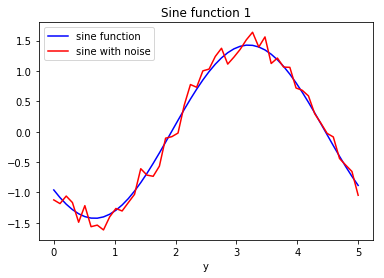

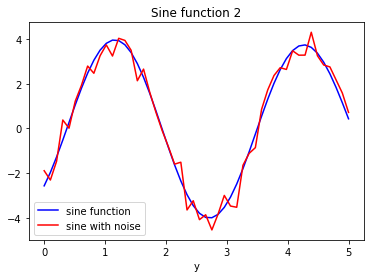

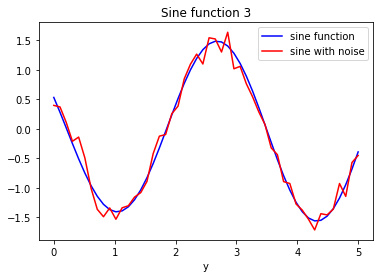

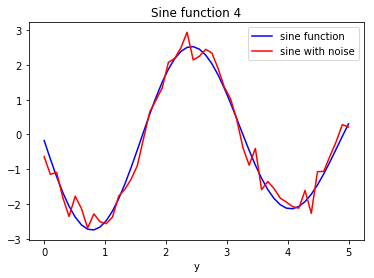

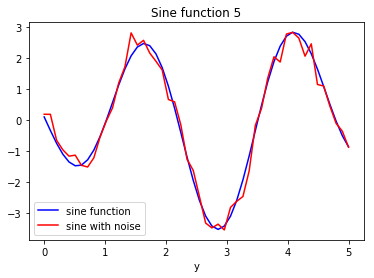

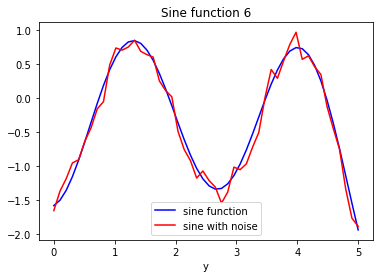

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
sin_func = sample_sine_functions(6)
for i in range(len(sin_func)):

    # Generate equally spaced data in x and function in y
    x = np.linspace(0, 5, 50)
    y = sin_func[i](x) 
    
    plt.figure(i)
    plt.title("Sine function %s" % (i+1))
    plt.xlabel("x")
    plt.xlabel("y")
    plt.plot(x,y, color = 'blue', label = 'sine function')
    plt.plot(x,noisy(y), color = 'red', label = 'sine with noise')
    plt.legend()
    plt.show()
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (batch_size, hidden_size) followed by a Linear layer which takes a (batch_size, hidden_size) vector as input and outputs a tensor with shape (batch_size, 1).

To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [6]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        
        # START TODO ############
        # input_size = 1
        self.LSTM_1 = LSTM(1, hidden_size)
        
        # output_size of lowest layer is hidden_size -> input size of next LSTM hidden_size
        self.LSTM_2 = LSTM(hidden_size, hidden_size)
        
        # scale output of LSTM
        # size of input sample: hidden_size
        # size of output sample: 1
        self.Linear = nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.shift zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        
        # 1) pad the input sequence at the end    
        # 6/2 = 3 <= input dim
        x = F.pad(x, (0,0,0,0,0, self.shift), 'constant', 0)
        
        # 2) LSTM_1
        hidden_1 = self.LSTM_1.forward(x)
        
        # 3) Cuts the first self.interval outputs
        hidden_1 = hidden_1[0]
        hidden_1 = hidden_1[self.shift :, :, :]
                
        # 4) LSTM_2
        hidden_2 = self.LSTM_2.forward(hidden_1)

        # 5) Linear layer
        out = self.Linear.forward(hidden_2[0])
        
        return out

        # END TODO #############

In [7]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [8]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    for epoch in range(num_epochs):
        # START TODO #############
        # num_samples -> num_functions for noisy data
        for batch_idx in range(num_functions // batch_size):
            batch_noisy = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            # without picking one
            output = model(batch_noisy)
            labels_batch = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels_batch, output)
            loss.backward()
            optimizer.step()
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        # END TODO ##############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:4405.5009765625
epoch: 0, validation loss:4405.5009765625


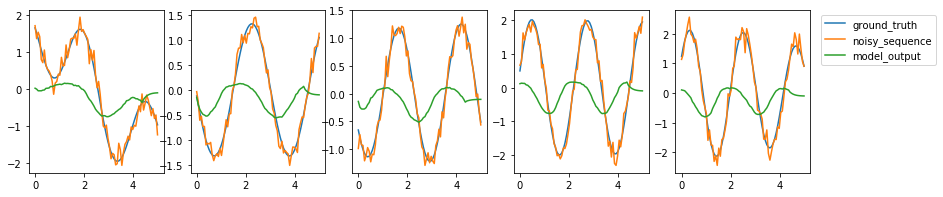

-564.6369% of noise removed.
epoch: 1, train loss:4271.08203125
epoch: 1, validation loss:4271.08203125
epoch: 2, train loss:6838.2998046875
epoch: 2, validation loss:6838.2998046875
epoch: 3, train loss:24707.123046875
epoch: 3, validation loss:24707.12109375
epoch: 4, train loss:8349.3408203125
epoch: 4, validation loss:8349.3408203125
epoch: 5, train loss:8879.5556640625
epoch: 5, validation loss:8879.5556640625
epoch: 6, train loss:7409.0693359375
epoch: 6, validation loss:7409.0693359375
epoch: 7, train loss:9993.798828125
epoch: 7, validation loss:9993.798828125
epoch: 8, train loss:6962.57958984375
epoch: 8, validation loss:6962.57958984375
epoch: 9, train loss:8315.0546875
epoch: 9, validation loss:8315.0546875
epoch: 10, train loss:7117.38330078125
epoch: 10, validation loss:7117.38330078125


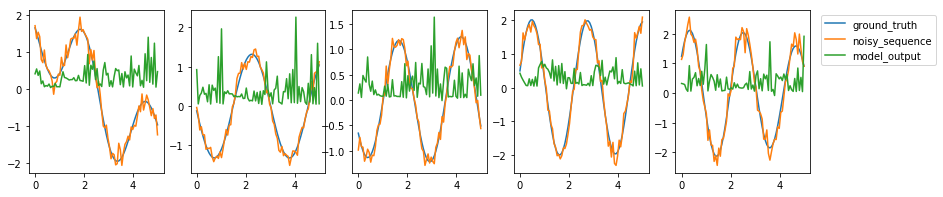

-771.5926% of noise removed.
epoch: 11, train loss:7869.1923828125
epoch: 11, validation loss:7869.1923828125
epoch: 12, train loss:9447.3759765625
epoch: 12, validation loss:9447.3759765625
epoch: 13, train loss:7987.40576171875
epoch: 13, validation loss:7987.40625
epoch: 14, train loss:5906.13818359375
epoch: 14, validation loss:5906.13818359375
epoch: 15, train loss:8321.3427734375
epoch: 15, validation loss:8321.341796875
epoch: 16, train loss:10851.9765625
epoch: 16, validation loss:10851.9765625
epoch: 17, train loss:9996.05859375
epoch: 17, validation loss:9996.0595703125
epoch: 18, train loss:7237.47265625
epoch: 18, validation loss:7237.47265625
epoch: 19, train loss:5786.26025390625
epoch: 19, validation loss:5786.26025390625
epoch: 20, train loss:5961.732421875
epoch: 20, validation loss:5961.732421875


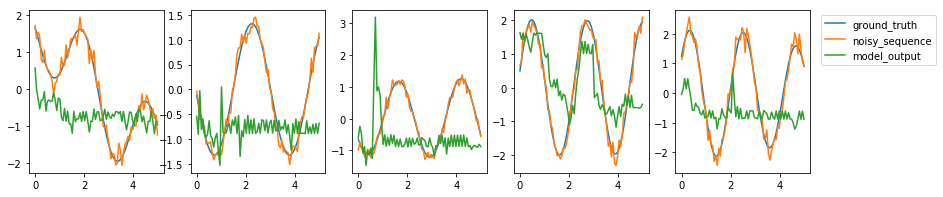

-704.3433% of noise removed.
epoch: 21, train loss:5706.931640625
epoch: 21, validation loss:5706.931640625
epoch: 22, train loss:7137.4423828125
epoch: 22, validation loss:7137.4423828125
epoch: 23, train loss:6934.4931640625
epoch: 23, validation loss:6934.4931640625
epoch: 24, train loss:5718.5673828125
epoch: 24, validation loss:5718.5673828125
epoch: 25, train loss:7152.40380859375
epoch: 25, validation loss:7152.4033203125
epoch: 26, train loss:6895.55419921875
epoch: 26, validation loss:6895.55419921875
epoch: 27, train loss:5403.8017578125
epoch: 27, validation loss:5403.80126953125
epoch: 28, train loss:5050.25048828125
epoch: 28, validation loss:5050.2509765625
epoch: 29, train loss:13385.8486328125
epoch: 29, validation loss:13385.849609375
epoch: 30, train loss:10251.9931640625
epoch: 30, validation loss:10251.9931640625


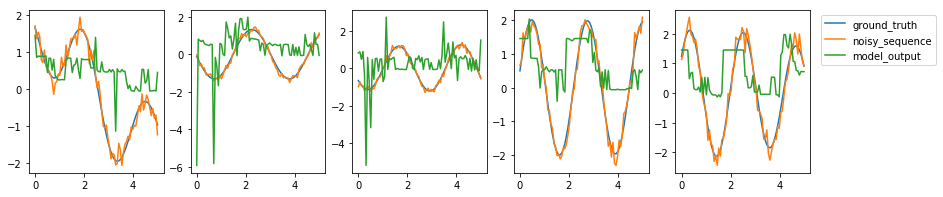

-725.9274% of noise removed.
epoch: 31, train loss:16760.42578125
epoch: 31, validation loss:16760.42578125
epoch: 32, train loss:18880.486328125
epoch: 32, validation loss:18880.486328125
epoch: 33, train loss:22112.849609375
epoch: 33, validation loss:22112.849609375
epoch: 34, train loss:18133.275390625
epoch: 34, validation loss:18133.275390625
epoch: 35, train loss:22482.126953125
epoch: 35, validation loss:22482.126953125
epoch: 36, train loss:23492.787109375
epoch: 36, validation loss:23492.787109375
epoch: 37, train loss:28115.107421875
epoch: 37, validation loss:28115.107421875
epoch: 38, train loss:22742.544921875
epoch: 38, validation loss:22742.544921875
epoch: 39, train loss:18975.83984375
epoch: 39, validation loss:18975.83984375
epoch: 40, train loss:20743.9296875
epoch: 40, validation loss:20743.9296875


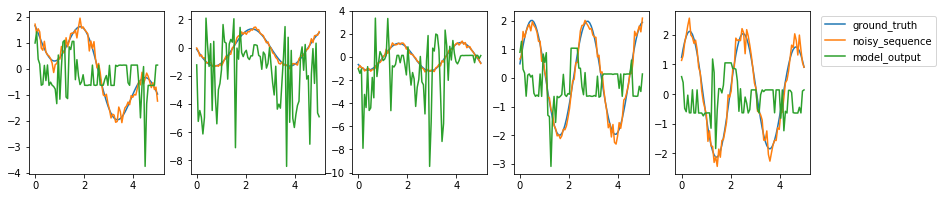

-1139.8840% of noise removed.
epoch: 41, train loss:24783.693359375
epoch: 41, validation loss:24783.693359375
epoch: 42, train loss:25489.77734375
epoch: 42, validation loss:25489.77734375
epoch: 43, train loss:21125.201171875
epoch: 43, validation loss:21125.201171875
epoch: 44, train loss:16964.9921875
epoch: 44, validation loss:16964.990234375
epoch: 45, train loss:12714.203125
epoch: 45, validation loss:12714.203125
epoch: 46, train loss:15871.24609375
epoch: 46, validation loss:15871.24609375
epoch: 47, train loss:21842.12109375
epoch: 47, validation loss:21842.12109375
epoch: 48, train loss:24247.6015625
epoch: 48, validation loss:24247.6015625
epoch: 49, train loss:23908.39453125
epoch: 49, validation loss:23908.39453125
epoch: 50, train loss:17285.365234375
epoch: 50, validation loss:17285.365234375


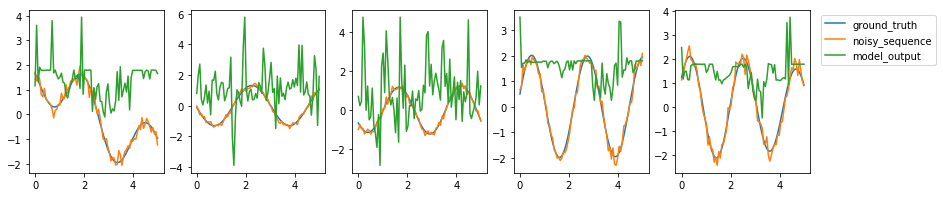

-1243.7485% of noise removed.
epoch: 51, train loss:11703.1201171875
epoch: 51, validation loss:11703.1201171875
epoch: 52, train loss:10113.69921875
epoch: 52, validation loss:10113.6982421875
epoch: 53, train loss:12675.4375
epoch: 53, validation loss:12675.4375
epoch: 54, train loss:16210.705078125
epoch: 54, validation loss:16210.705078125
epoch: 55, train loss:20065.28125
epoch: 55, validation loss:20065.28125
epoch: 56, train loss:22593.4921875
epoch: 56, validation loss:22593.4921875
epoch: 57, train loss:23795.39453125
epoch: 57, validation loss:23795.39453125
epoch: 58, train loss:21799.09765625
epoch: 58, validation loss:21799.09765625
epoch: 59, train loss:18615.150390625
epoch: 59, validation loss:18615.150390625
epoch: 60, train loss:15216.447265625
epoch: 60, validation loss:15216.447265625


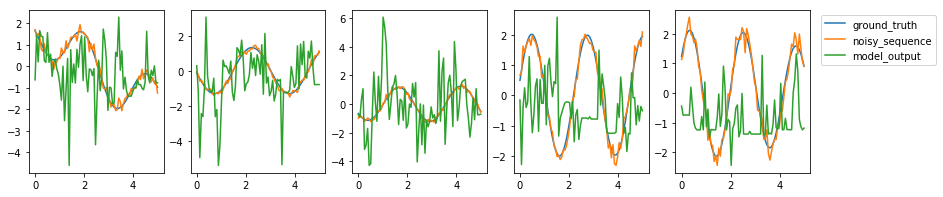

-1137.1383% of noise removed.
epoch: 61, train loss:15845.5126953125
epoch: 61, validation loss:15845.5126953125
epoch: 62, train loss:19156.7734375
epoch: 62, validation loss:19156.7734375
epoch: 63, train loss:19986.54296875
epoch: 63, validation loss:19986.54296875
epoch: 64, train loss:20418.31640625
epoch: 64, validation loss:20418.31640625
epoch: 65, train loss:20046.2578125
epoch: 65, validation loss:20046.2578125
epoch: 66, train loss:19580.017578125
epoch: 66, validation loss:19580.017578125
epoch: 67, train loss:19423.501953125
epoch: 67, validation loss:19423.501953125
epoch: 68, train loss:17249.583984375
epoch: 68, validation loss:17249.583984375
epoch: 69, train loss:14996.6640625
epoch: 69, validation loss:14996.6640625
epoch: 70, train loss:12723.1044921875
epoch: 70, validation loss:12723.1044921875


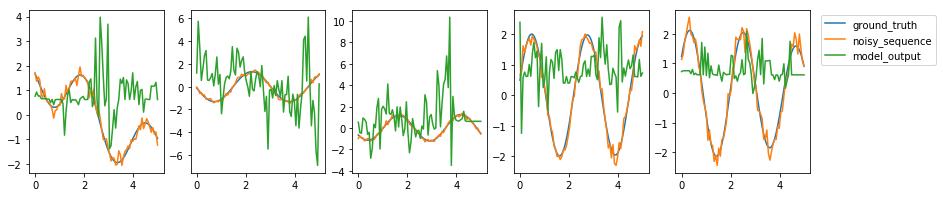

-1007.1268% of noise removed.
epoch: 71, train loss:10981.9130859375
epoch: 71, validation loss:10981.9130859375
epoch: 72, train loss:10260.19921875
epoch: 72, validation loss:10260.19921875
epoch: 73, train loss:9203.986328125
epoch: 73, validation loss:9203.986328125
epoch: 74, train loss:8788.314453125
epoch: 74, validation loss:8788.314453125
epoch: 75, train loss:7849.587890625
epoch: 75, validation loss:7849.587890625
epoch: 76, train loss:8767.5537109375
epoch: 76, validation loss:8767.5537109375
epoch: 77, train loss:8351.3232421875
epoch: 77, validation loss:8351.322265625
epoch: 78, train loss:8588.6923828125
epoch: 78, validation loss:8588.6923828125
epoch: 79, train loss:8649.25390625
epoch: 79, validation loss:8649.25390625
epoch: 80, train loss:8027.2529296875
epoch: 80, validation loss:8027.2529296875


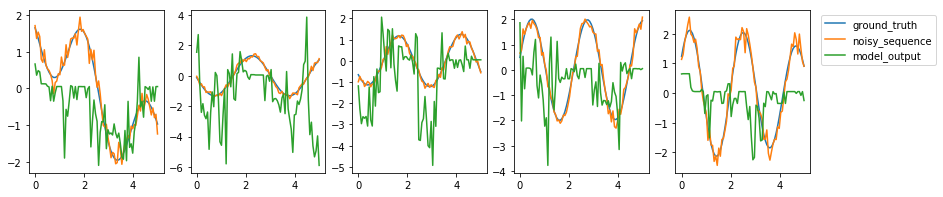

-759.8372% of noise removed.
epoch: 81, train loss:8672.841796875
epoch: 81, validation loss:8672.841796875
epoch: 82, train loss:8244.8310546875
epoch: 82, validation loss:8244.8310546875
epoch: 83, train loss:7658.03662109375
epoch: 83, validation loss:7658.03662109375
epoch: 84, train loss:7726.8955078125
epoch: 84, validation loss:7726.89501953125
epoch: 85, train loss:7947.85791015625
epoch: 85, validation loss:7947.85791015625
epoch: 86, train loss:7591.47265625
epoch: 86, validation loss:7591.47265625
epoch: 87, train loss:7844.365234375
epoch: 87, validation loss:7844.36474609375
epoch: 88, train loss:7435.6298828125
epoch: 88, validation loss:7435.62939453125
epoch: 89, train loss:7708.07763671875
epoch: 89, validation loss:7708.07763671875
epoch: 90, train loss:7339.0029296875
epoch: 90, validation loss:7339.0029296875


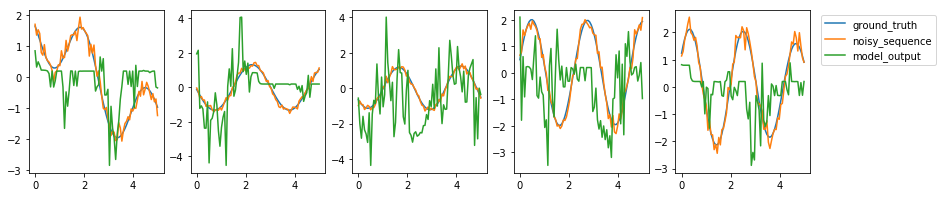

-731.9624% of noise removed.
epoch: 91, train loss:6676.10888671875
epoch: 91, validation loss:6676.10888671875
epoch: 92, train loss:6366.4189453125
epoch: 92, validation loss:6366.4189453125
epoch: 93, train loss:6852.26513671875
epoch: 93, validation loss:6852.26513671875
epoch: 94, train loss:6355.30810546875
epoch: 94, validation loss:6355.30810546875
epoch: 95, train loss:6664.02294921875
epoch: 95, validation loss:6664.02294921875
epoch: 96, train loss:6433.22607421875
epoch: 96, validation loss:6433.22607421875
epoch: 97, train loss:6649.12158203125
epoch: 97, validation loss:6649.12158203125
epoch: 98, train loss:6650.2509765625
epoch: 98, validation loss:6650.2509765625
epoch: 99, train loss:6590.6884765625
epoch: 99, validation loss:6590.6884765625
epoch: 100, train loss:6559.93798828125
epoch: 100, validation loss:6559.93798828125


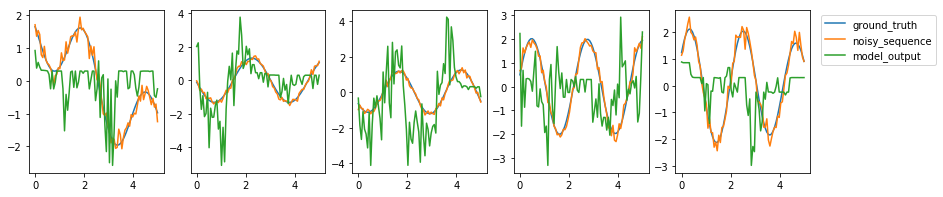

-698.7748% of noise removed.


In [9]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration| 32.52%               |

epoch: 0, train loss:5069.205078125
epoch: 0, validation loss:5069.205078125


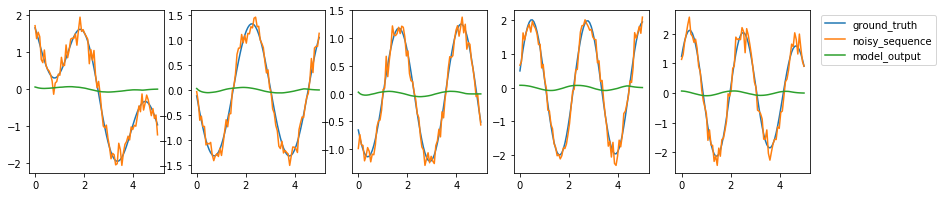

-615.4800% of noise removed.
epoch: 1, train loss:2870.918212890625
epoch: 1, validation loss:2870.918212890625
epoch: 2, train loss:4493.83935546875
epoch: 2, validation loss:4493.83935546875
epoch: 3, train loss:6694.90869140625
epoch: 3, validation loss:6694.90869140625
epoch: 4, train loss:5073.97021484375
epoch: 4, validation loss:5073.97021484375
epoch: 5, train loss:5165.6455078125
epoch: 5, validation loss:5165.6455078125
epoch: 6, train loss:5125.71435546875
epoch: 6, validation loss:5125.71435546875
epoch: 7, train loss:5030.42578125
epoch: 7, validation loss:5030.42578125
epoch: 8, train loss:4845.888671875
epoch: 8, validation loss:4845.888671875
epoch: 9, train loss:4485.84619140625
epoch: 9, validation loss:4485.84619140625
epoch: 10, train loss:3314.506591796875
epoch: 10, validation loss:3314.506591796875


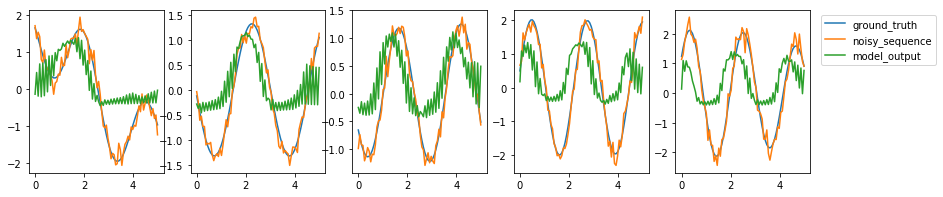

-463.2477% of noise removed.
epoch: 11, train loss:4797.71240234375
epoch: 11, validation loss:4797.71240234375
epoch: 12, train loss:3049.771240234375
epoch: 12, validation loss:3049.771240234375
epoch: 13, train loss:4545.677734375
epoch: 13, validation loss:4545.677734375
epoch: 14, train loss:4257.04345703125
epoch: 14, validation loss:4257.0439453125
epoch: 15, train loss:4283.5576171875
epoch: 15, validation loss:4283.5576171875
epoch: 16, train loss:3743.650146484375
epoch: 16, validation loss:3743.650146484375
epoch: 17, train loss:3417.4853515625
epoch: 17, validation loss:3417.4853515625
epoch: 18, train loss:5104.29541015625
epoch: 18, validation loss:5104.294921875
epoch: 19, train loss:4397.54345703125
epoch: 19, validation loss:4397.54345703125
epoch: 20, train loss:3438.694091796875
epoch: 20, validation loss:3438.694091796875


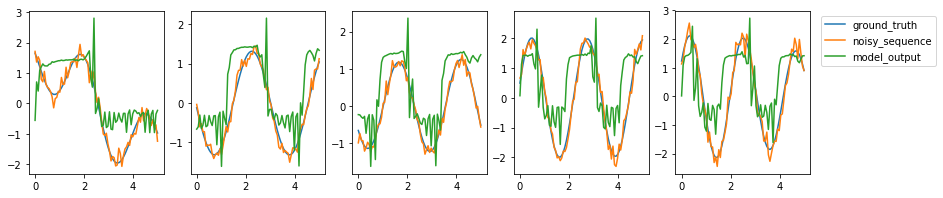

-492.0801% of noise removed.
epoch: 21, train loss:3250.867919921875
epoch: 21, validation loss:3250.867919921875
epoch: 22, train loss:3455.130126953125
epoch: 22, validation loss:3455.130126953125
epoch: 23, train loss:3876.464111328125
epoch: 23, validation loss:3876.4638671875
epoch: 24, train loss:4104.5185546875
epoch: 24, validation loss:4104.51904296875
epoch: 25, train loss:4361.3076171875
epoch: 25, validation loss:4361.30712890625
epoch: 26, train loss:4797.453125
epoch: 26, validation loss:4797.453125
epoch: 27, train loss:3861.025634765625
epoch: 27, validation loss:3861.025634765625
epoch: 28, train loss:4718.099609375
epoch: 28, validation loss:4718.099609375
epoch: 29, train loss:5207.64892578125
epoch: 29, validation loss:5207.64892578125
epoch: 30, train loss:3808.294189453125
epoch: 30, validation loss:3808.294189453125


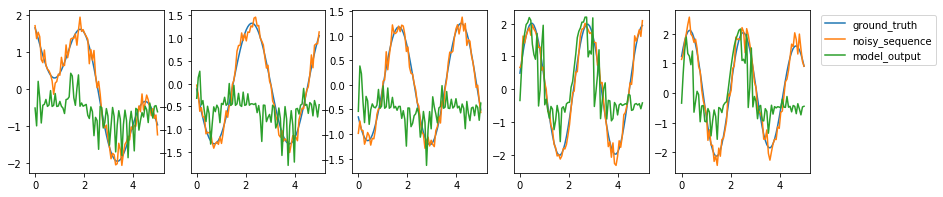

-533.3135% of noise removed.
epoch: 31, train loss:3901.21337890625
epoch: 31, validation loss:3901.21337890625
epoch: 32, train loss:5920.6865234375
epoch: 32, validation loss:5920.68603515625
epoch: 33, train loss:5336.48583984375
epoch: 33, validation loss:5336.48583984375
epoch: 34, train loss:3658.99462890625
epoch: 34, validation loss:3658.99462890625
epoch: 35, train loss:4421.8076171875
epoch: 35, validation loss:4421.8076171875
epoch: 36, train loss:6486.8271484375
epoch: 36, validation loss:6486.8271484375
epoch: 37, train loss:6506.24365234375
epoch: 37, validation loss:6506.2431640625
epoch: 38, train loss:4357.0947265625
epoch: 38, validation loss:4357.0947265625
epoch: 39, train loss:3426.125244140625
epoch: 39, validation loss:3426.125244140625
epoch: 40, train loss:5094.4111328125
epoch: 40, validation loss:5094.41162109375


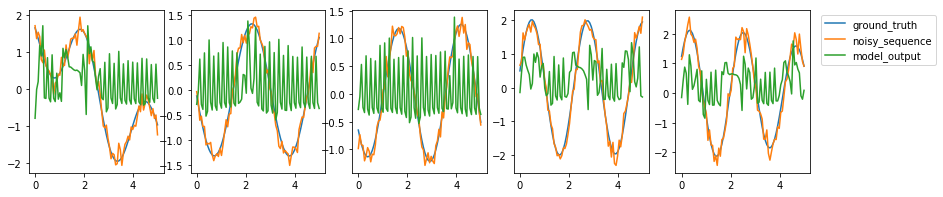

-618.2158% of noise removed.
epoch: 41, train loss:7452.7998046875
epoch: 41, validation loss:7452.7998046875
epoch: 42, train loss:7859.4169921875
epoch: 42, validation loss:7859.4169921875
epoch: 43, train loss:6141.193359375
epoch: 43, validation loss:6141.193359375
epoch: 44, train loss:3947.00390625
epoch: 44, validation loss:3947.00390625
epoch: 45, train loss:3158.23779296875
epoch: 45, validation loss:3158.238037109375
epoch: 46, train loss:4158.3017578125
epoch: 46, validation loss:4158.3017578125
epoch: 47, train loss:6073.75634765625
epoch: 47, validation loss:6073.7568359375
epoch: 48, train loss:7615.49658203125
epoch: 48, validation loss:7615.49609375
epoch: 49, train loss:7926.99951171875
epoch: 49, validation loss:7926.99951171875
epoch: 50, train loss:6971.6611328125
epoch: 50, validation loss:6971.6611328125


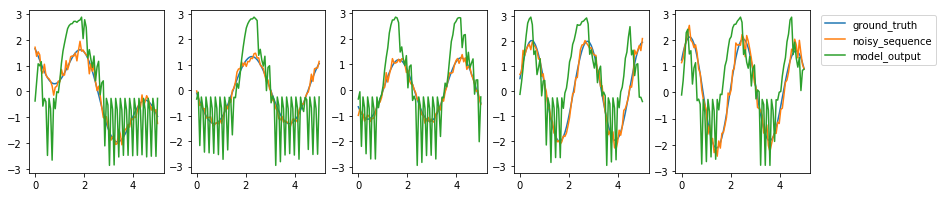

-752.8293% of noise removed.
epoch: 51, train loss:5481.77978515625
epoch: 51, validation loss:5481.77978515625
epoch: 52, train loss:4011.000244140625
epoch: 52, validation loss:4011.000244140625
epoch: 53, train loss:3227.24267578125
epoch: 53, validation loss:3227.24267578125
epoch: 54, train loss:3179.909423828125
epoch: 54, validation loss:3179.90966796875
epoch: 55, train loss:3707.34521484375
epoch: 55, validation loss:3707.344970703125
epoch: 56, train loss:4508.43701171875
epoch: 56, validation loss:4508.43701171875
epoch: 57, train loss:5335.12255859375
epoch: 57, validation loss:5335.12255859375
epoch: 58, train loss:5936.6328125
epoch: 58, validation loss:5936.6328125
epoch: 59, train loss:6185.7568359375
epoch: 59, validation loss:6185.7568359375
epoch: 60, train loss:6029.1689453125
epoch: 60, validation loss:6029.16845703125


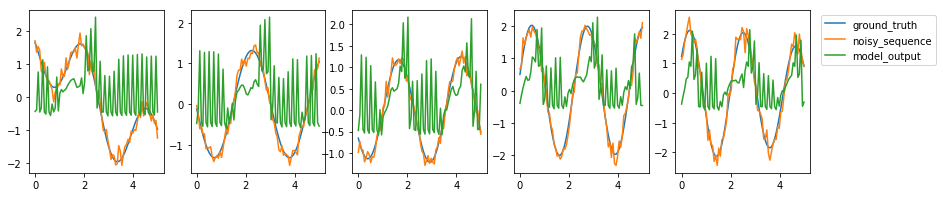

-683.5642% of noise removed.
epoch: 61, train loss:5525.57080078125
epoch: 61, validation loss:5525.57080078125
epoch: 62, train loss:4863.07666015625
epoch: 62, validation loss:4863.076171875
epoch: 63, train loss:4206.6337890625
epoch: 63, validation loss:4206.6337890625
epoch: 64, train loss:3691.6611328125
epoch: 64, validation loss:3691.660888671875
epoch: 65, train loss:3388.75048828125
epoch: 65, validation loss:3388.750244140625
epoch: 66, train loss:3302.61474609375
epoch: 66, validation loss:3302.61474609375
epoch: 67, train loss:3342.073486328125
epoch: 67, validation loss:3342.0732421875
epoch: 68, train loss:3473.424560546875
epoch: 68, validation loss:3473.4248046875
epoch: 69, train loss:3618.895751953125
epoch: 69, validation loss:3618.8955078125
epoch: 70, train loss:3844.911376953125
epoch: 70, validation loss:3844.911376953125


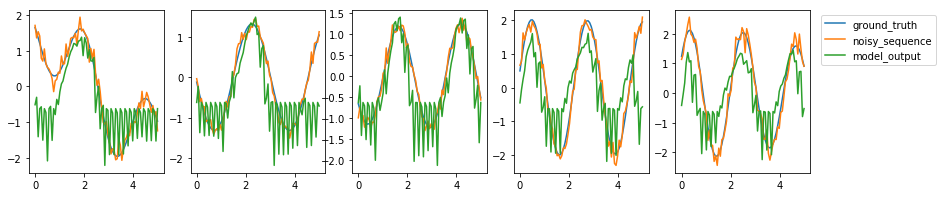

-523.1134% of noise removed.
epoch: 71, train loss:4071.509765625
epoch: 71, validation loss:4071.509765625
epoch: 72, train loss:4121.654296875
epoch: 72, validation loss:4121.654296875
epoch: 73, train loss:4190.0751953125
epoch: 73, validation loss:4190.0751953125
epoch: 74, train loss:4215.30908203125
epoch: 74, validation loss:4215.30859375
epoch: 75, train loss:4179.89208984375
epoch: 75, validation loss:4179.89208984375
epoch: 76, train loss:4110.912109375
epoch: 76, validation loss:4110.912109375
epoch: 77, train loss:4024.676513671875
epoch: 77, validation loss:4024.6767578125
epoch: 78, train loss:3899.93115234375
epoch: 78, validation loss:3899.93115234375
epoch: 79, train loss:3786.21826171875
epoch: 79, validation loss:3786.21826171875
epoch: 80, train loss:3683.659912109375
epoch: 80, validation loss:3683.659912109375


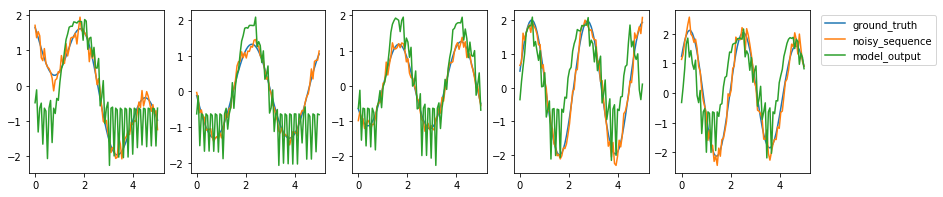

-525.0557% of noise removed.
epoch: 81, train loss:3563.919677734375
epoch: 81, validation loss:3563.919921875
epoch: 82, train loss:3473.771728515625
epoch: 82, validation loss:3473.771484375
epoch: 83, train loss:3405.383056640625
epoch: 83, validation loss:3405.383056640625
epoch: 84, train loss:3320.455078125
epoch: 84, validation loss:3320.454833984375
epoch: 85, train loss:3277.70166015625
epoch: 85, validation loss:3277.70166015625
epoch: 86, train loss:3229.274658203125
epoch: 86, validation loss:3229.274658203125
epoch: 87, train loss:3190.30517578125
epoch: 87, validation loss:3190.30517578125
epoch: 88, train loss:3151.1689453125
epoch: 88, validation loss:3151.169189453125
epoch: 89, train loss:3116.21875
epoch: 89, validation loss:3116.218505859375
epoch: 90, train loss:3088.066650390625
epoch: 90, validation loss:3088.066650390625


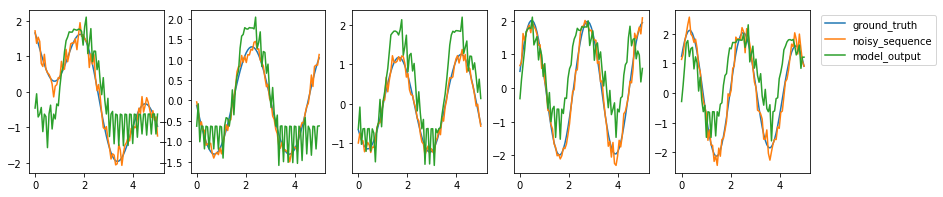

-481.5583% of noise removed.
epoch: 91, train loss:3063.81591796875
epoch: 91, validation loss:3063.816162109375
epoch: 92, train loss:3048.3974609375
epoch: 92, validation loss:3048.3974609375
epoch: 93, train loss:3020.057373046875
epoch: 93, validation loss:3020.057373046875
epoch: 94, train loss:3007.06005859375
epoch: 94, validation loss:3007.060302734375
epoch: 95, train loss:2997.038330078125
epoch: 95, validation loss:2997.038330078125
epoch: 96, train loss:2992.443115234375
epoch: 96, validation loss:2992.443359375
epoch: 97, train loss:2987.48291015625
epoch: 97, validation loss:2987.483154296875
epoch: 98, train loss:2984.111328125
epoch: 98, validation loss:2984.111328125
epoch: 99, train loss:2982.117431640625
epoch: 99, validation loss:2982.117431640625
epoch: 100, train loss:2981.196533203125
epoch: 100, validation loss:2981.196533203125


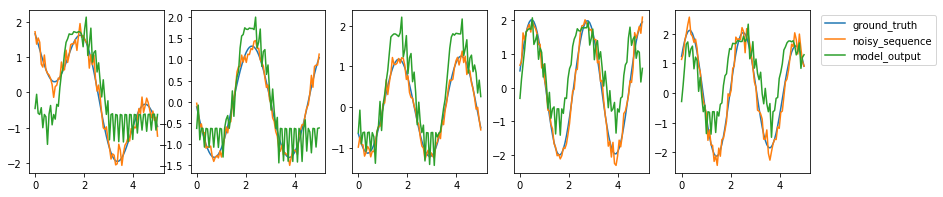

-471.0230% of noise removed.


In [13]:
# learning rate decreased
batch_size = 10
num_epochs = 101
learning_rate = 0.001
# noise removed: 471.0239%


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)


epoch: 0, train loss:5113.00439453125
epoch: 0, validation loss:5113.00439453125


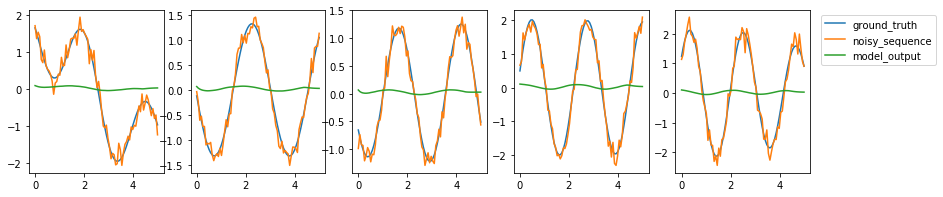

-618.8290% of noise removed.
epoch: 1, train loss:3178.34912109375
epoch: 1, validation loss:3178.34912109375
epoch: 2, train loss:4940.0029296875
epoch: 2, validation loss:4940.0029296875
epoch: 3, train loss:5134.1318359375
epoch: 3, validation loss:5134.1318359375
epoch: 4, train loss:5483.24951171875
epoch: 4, validation loss:5483.24951171875
epoch: 5, train loss:5647.603515625
epoch: 5, validation loss:5647.603515625
epoch: 6, train loss:4857.86865234375
epoch: 6, validation loss:4857.86865234375
epoch: 7, train loss:4576.01318359375
epoch: 7, validation loss:4576.01318359375
epoch: 8, train loss:3653.6767578125
epoch: 8, validation loss:3653.6767578125
epoch: 9, train loss:3742.060302734375
epoch: 9, validation loss:3742.060302734375
epoch: 10, train loss:4690.2333984375
epoch: 10, validation loss:4690.2333984375


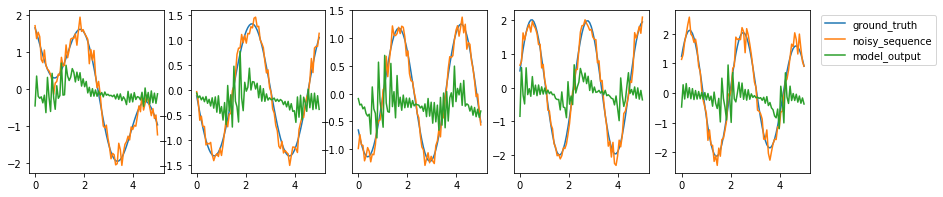

-601.7090% of noise removed.
epoch: 11, train loss:5384.62109375
epoch: 11, validation loss:5384.62109375
epoch: 12, train loss:5205.50341796875
epoch: 12, validation loss:5205.50341796875
epoch: 13, train loss:4256.953125
epoch: 13, validation loss:4256.953125
epoch: 14, train loss:3131.59033203125
epoch: 14, validation loss:3131.590576171875
epoch: 15, train loss:3944.22900390625
epoch: 15, validation loss:3944.22900390625
epoch: 16, train loss:2910.009765625
epoch: 16, validation loss:2910.009765625
epoch: 17, train loss:2687.655029296875
epoch: 17, validation loss:2687.655029296875
epoch: 18, train loss:3220.041748046875
epoch: 18, validation loss:3220.041748046875
epoch: 19, train loss:3283.479248046875
epoch: 19, validation loss:3283.479248046875
epoch: 20, train loss:2918.535400390625
epoch: 20, validation loss:2918.535400390625


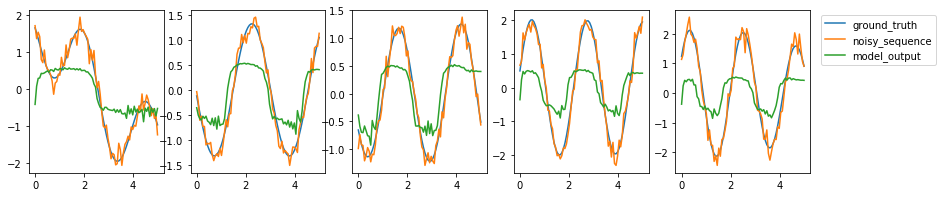

-427.4765% of noise removed.
epoch: 21, train loss:2513.37451171875
epoch: 21, validation loss:2513.37451171875
epoch: 22, train loss:2385.41748046875
epoch: 22, validation loss:2385.41748046875
epoch: 23, train loss:2386.32568359375
epoch: 23, validation loss:2386.32568359375
epoch: 24, train loss:3211.648681640625
epoch: 24, validation loss:3211.648681640625
epoch: 25, train loss:2757.125244140625
epoch: 25, validation loss:2757.125244140625
epoch: 26, train loss:1994.7894287109375
epoch: 26, validation loss:1994.78955078125
epoch: 27, train loss:2110.81494140625
epoch: 27, validation loss:2110.81494140625
epoch: 28, train loss:2138.7490234375
epoch: 28, validation loss:2138.7490234375
epoch: 29, train loss:2080.060302734375
epoch: 29, validation loss:2080.060302734375
epoch: 30, train loss:2028.5181884765625
epoch: 30, validation loss:2028.5181884765625


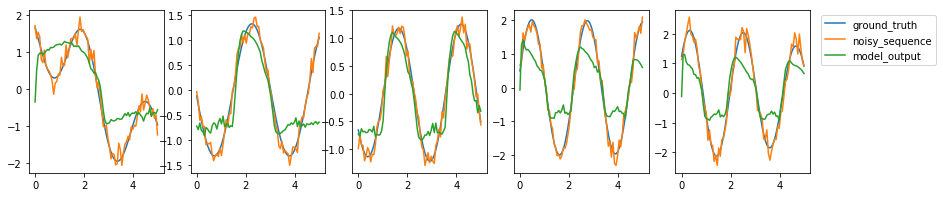

-334.2968% of noise removed.
epoch: 31, train loss:1958.2642822265625
epoch: 31, validation loss:1958.2642822265625
epoch: 32, train loss:2090.3505859375
epoch: 32, validation loss:2090.3505859375
epoch: 33, train loss:1721.1531982421875
epoch: 33, validation loss:1721.1531982421875
epoch: 34, train loss:1825.333740234375
epoch: 34, validation loss:1825.333740234375
epoch: 35, train loss:1656.40869140625
epoch: 35, validation loss:1656.40869140625
epoch: 36, train loss:1662.710205078125
epoch: 36, validation loss:1662.710205078125
epoch: 37, train loss:1924.0052490234375
epoch: 37, validation loss:1924.0054931640625
epoch: 38, train loss:1910.3668212890625
epoch: 38, validation loss:1910.3668212890625
epoch: 39, train loss:1685.72705078125
epoch: 39, validation loss:1685.72705078125
epoch: 40, train loss:2002.4349365234375
epoch: 40, validation loss:2002.4349365234375


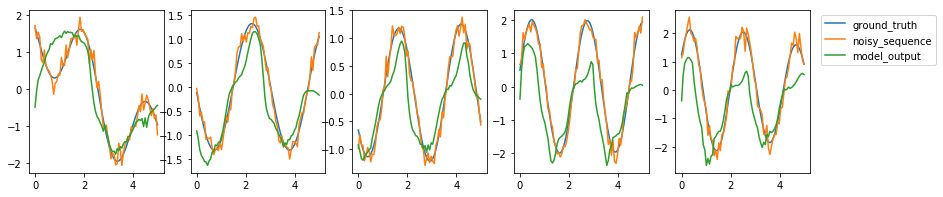

-318.3787% of noise removed.
epoch: 41, train loss:2183.510009765625
epoch: 41, validation loss:2183.510009765625
epoch: 42, train loss:1776.1390380859375
epoch: 42, validation loss:1776.13916015625
epoch: 43, train loss:1509.4500732421875
epoch: 43, validation loss:1509.4500732421875
epoch: 44, train loss:1682.6708984375
epoch: 44, validation loss:1682.6708984375
epoch: 45, train loss:1596.5516357421875
epoch: 45, validation loss:1596.5516357421875
epoch: 46, train loss:1452.4488525390625
epoch: 46, validation loss:1452.4488525390625
epoch: 47, train loss:1442.0084228515625
epoch: 47, validation loss:1442.0084228515625
epoch: 48, train loss:1327.6724853515625
epoch: 48, validation loss:1327.672607421875
epoch: 49, train loss:1186.7318115234375
epoch: 49, validation loss:1186.7318115234375
epoch: 50, train loss:1237.7286376953125
epoch: 50, validation loss:1237.7286376953125


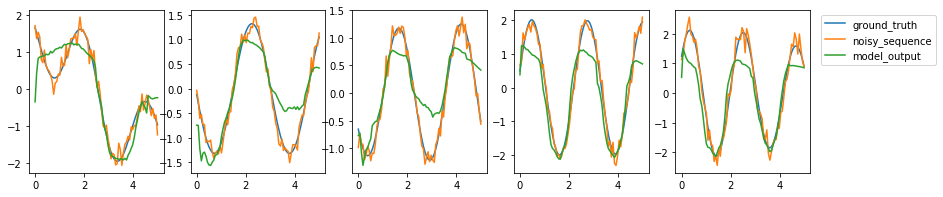

-238.0649% of noise removed.
epoch: 51, train loss:1408.603271484375
epoch: 51, validation loss:1408.6033935546875
epoch: 52, train loss:1457.3345947265625
epoch: 52, validation loss:1457.3348388671875
epoch: 53, train loss:1329.7127685546875
epoch: 53, validation loss:1329.7127685546875
epoch: 54, train loss:1169.9359130859375
epoch: 54, validation loss:1169.9359130859375
epoch: 55, train loss:1090.5458984375
epoch: 55, validation loss:1090.5458984375
epoch: 56, train loss:1107.818603515625
epoch: 56, validation loss:1107.818603515625
epoch: 57, train loss:1176.59375
epoch: 57, validation loss:1176.5936279296875
epoch: 58, train loss:1206.3638916015625
epoch: 58, validation loss:1206.3638916015625
epoch: 59, train loss:1153.041015625
epoch: 59, validation loss:1153.041015625
epoch: 60, train loss:1087.3780517578125
epoch: 60, validation loss:1087.3780517578125


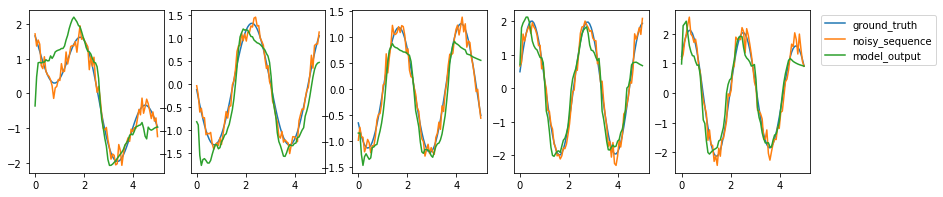

-221.3709% of noise removed.
epoch: 61, train loss:1076.5439453125
epoch: 61, validation loss:1076.5440673828125
epoch: 62, train loss:1090.0572509765625
epoch: 62, validation loss:1090.0572509765625
epoch: 63, train loss:1060.306396484375
epoch: 63, validation loss:1060.306396484375
epoch: 64, train loss:987.531982421875
epoch: 64, validation loss:987.531982421875
epoch: 65, train loss:931.2206420898438
epoch: 65, validation loss:931.2206420898438
epoch: 66, train loss:936.3436889648438
epoch: 66, validation loss:936.3436889648438
epoch: 67, train loss:996.6339721679688
epoch: 67, validation loss:996.6339721679688
epoch: 68, train loss:1094.341064453125
epoch: 68, validation loss:1094.341064453125
epoch: 69, train loss:1194.494140625
epoch: 69, validation loss:1194.494140625
epoch: 70, train loss:1248.02734375
epoch: 70, validation loss:1248.0274658203125


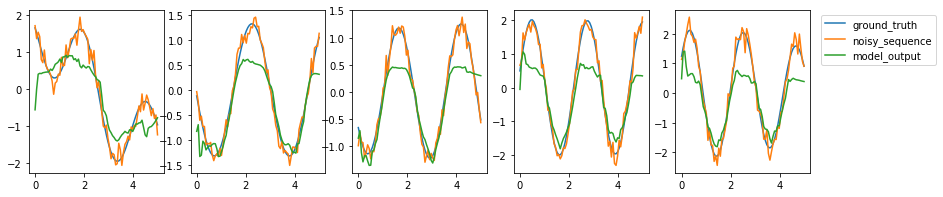

-231.8046% of noise removed.
epoch: 71, train loss:1219.8338623046875
epoch: 71, validation loss:1219.8338623046875
epoch: 72, train loss:1113.2840576171875
epoch: 72, validation loss:1113.2840576171875
epoch: 73, train loss:964.8986206054688
epoch: 73, validation loss:964.8986206054688
epoch: 74, train loss:846.9014892578125
epoch: 74, validation loss:846.9014892578125
epoch: 75, train loss:790.6103515625
epoch: 75, validation loss:790.6103515625
epoch: 76, train loss:778.717041015625
epoch: 76, validation loss:778.717041015625
epoch: 77, train loss:775.026611328125
epoch: 77, validation loss:775.0266723632812
epoch: 78, train loss:758.701171875
epoch: 78, validation loss:758.701171875
epoch: 79, train loss:745.8928833007812
epoch: 79, validation loss:745.8928833007812
epoch: 80, train loss:784.0614624023438
epoch: 80, validation loss:784.0614624023438


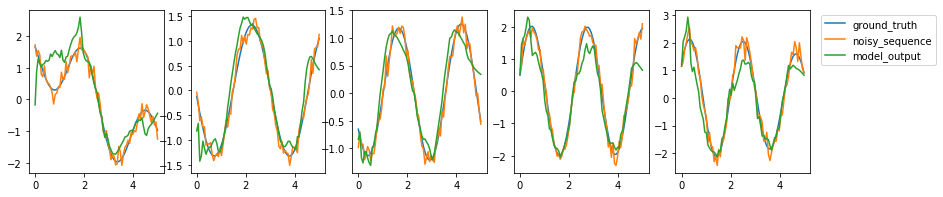

-163.2155% of noise removed.
epoch: 81, train loss:850.6819458007812
epoch: 81, validation loss:850.6819458007812
epoch: 82, train loss:866.192626953125
epoch: 82, validation loss:866.192626953125
epoch: 83, train loss:812.4453125
epoch: 83, validation loss:812.4453125
epoch: 84, train loss:769.1622924804688
epoch: 84, validation loss:769.1622924804688
epoch: 85, train loss:739.318359375
epoch: 85, validation loss:739.3182373046875
epoch: 86, train loss:690.8457641601562
epoch: 86, validation loss:690.8458251953125
epoch: 87, train loss:635.9395751953125
epoch: 87, validation loss:635.9395751953125
epoch: 88, train loss:609.709716796875
epoch: 88, validation loss:609.709716796875
epoch: 89, train loss:622.4624633789062
epoch: 89, validation loss:622.4625244140625
epoch: 90, train loss:653.939208984375
epoch: 90, validation loss:653.9392700195312


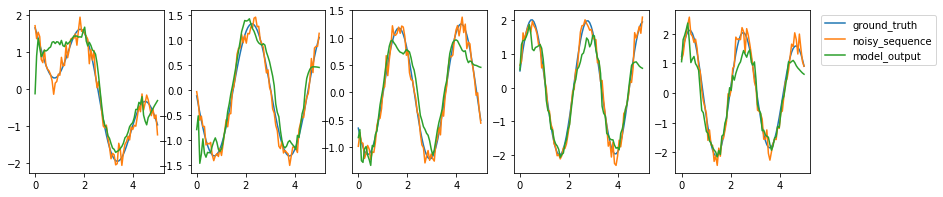

-142.9473% of noise removed.
epoch: 91, train loss:679.1625366210938
epoch: 91, validation loss:679.1625366210938
epoch: 92, train loss:679.096923828125
epoch: 92, validation loss:679.096923828125
epoch: 93, train loss:655.9703369140625
epoch: 93, validation loss:655.9703369140625
epoch: 94, train loss:626.0821533203125
epoch: 94, validation loss:626.0821533203125
epoch: 95, train loss:608.8401489257812
epoch: 95, validation loss:608.8401489257812
epoch: 96, train loss:613.5684814453125
epoch: 96, validation loss:613.5684814453125
epoch: 97, train loss:642.439453125
epoch: 97, validation loss:642.4393920898438
epoch: 98, train loss:685.9319458007812
epoch: 98, validation loss:685.9319458007812
epoch: 99, train loss:731.2091674804688
epoch: 99, validation loss:731.209228515625
epoch: 100, train loss:766.374267578125
epoch: 100, validation loss:766.3742065429688


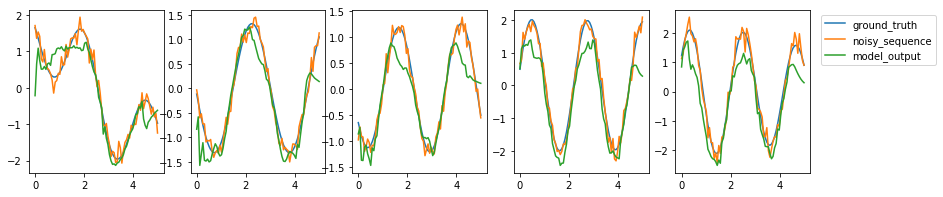

-163.0072% of noise removed.
epoch: 101, train loss:782.5346069335938
epoch: 101, validation loss:782.5345458984375
epoch: 102, train loss:776.6239013671875
epoch: 102, validation loss:776.6239013671875
epoch: 103, train loss:749.5469970703125
epoch: 103, validation loss:749.5469970703125
epoch: 104, train loss:707.1384887695312
epoch: 104, validation loss:707.1384887695312
epoch: 105, train loss:657.1331787109375
epoch: 105, validation loss:657.1331787109375
epoch: 106, train loss:606.6956176757812
epoch: 106, validation loss:606.6956176757812
epoch: 107, train loss:563.3387451171875
epoch: 107, validation loss:563.3388061523438
epoch: 108, train loss:530.1285400390625
epoch: 108, validation loss:530.1285400390625
epoch: 109, train loss:513.848388671875
epoch: 109, validation loss:513.848388671875
epoch: 110, train loss:507.1541748046875
epoch: 110, validation loss:507.1541748046875


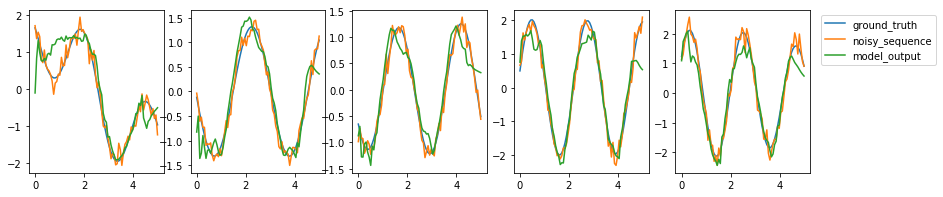

-112.7716% of noise removed.
epoch: 111, train loss:509.1231689453125
epoch: 111, validation loss:509.1231689453125
epoch: 112, train loss:516.837890625
epoch: 112, validation loss:516.837890625
epoch: 113, train loss:526.067626953125
epoch: 113, validation loss:526.067626953125
epoch: 114, train loss:532.0576171875
epoch: 114, validation loss:532.0576171875
epoch: 115, train loss:533.6519775390625
epoch: 115, validation loss:533.6519775390625
epoch: 116, train loss:528.939453125
epoch: 116, validation loss:528.939453125
epoch: 117, train loss:519.3827514648438
epoch: 117, validation loss:519.3828125
epoch: 118, train loss:507.00567626953125
epoch: 118, validation loss:507.0057067871094
epoch: 119, train loss:494.1467590332031
epoch: 119, validation loss:494.1467590332031
epoch: 120, train loss:482.6813659667969
epoch: 120, validation loss:482.6813659667969


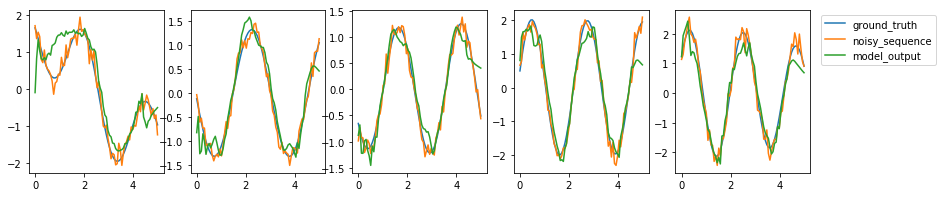

-109.2062% of noise removed.
epoch: 121, train loss:473.895263671875
epoch: 121, validation loss:473.895263671875
epoch: 122, train loss:468.59912109375
epoch: 122, validation loss:468.59918212890625
epoch: 123, train loss:466.5623474121094
epoch: 123, validation loss:466.5623474121094
epoch: 124, train loss:467.26287841796875
epoch: 124, validation loss:467.2628479003906
epoch: 125, train loss:470.0271301269531
epoch: 125, validation loss:470.027099609375
epoch: 126, train loss:474.15240478515625
epoch: 126, validation loss:474.1524353027344
epoch: 127, train loss:478.9981994628906
epoch: 127, validation loss:478.9981994628906
epoch: 128, train loss:484.02362060546875
epoch: 128, validation loss:484.02362060546875
epoch: 129, train loss:488.8063659667969
epoch: 129, validation loss:488.8063049316406
epoch: 130, train loss:493.04766845703125
epoch: 130, validation loss:493.0475769042969


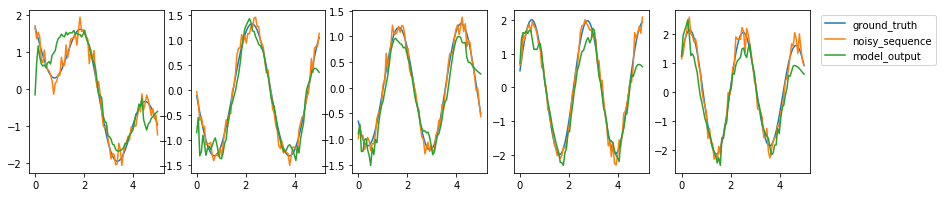

-112.3233% of noise removed.
epoch: 131, train loss:496.5617370605469
epoch: 131, validation loss:496.5617370605469
epoch: 132, train loss:499.2613525390625
epoch: 132, validation loss:499.2613525390625
epoch: 133, train loss:501.13751220703125
epoch: 133, validation loss:501.13751220703125
epoch: 134, train loss:502.2420654296875
epoch: 134, validation loss:502.2420654296875
epoch: 135, train loss:502.6671142578125
epoch: 135, validation loss:502.6671142578125
epoch: 136, train loss:502.52947998046875
epoch: 136, validation loss:502.52947998046875
epoch: 137, train loss:501.9555969238281
epoch: 137, validation loss:501.9555969238281
epoch: 138, train loss:501.0716247558594
epoch: 138, validation loss:501.0716247558594
epoch: 139, train loss:499.9934997558594
epoch: 139, validation loss:499.9934997558594
epoch: 140, train loss:498.82415771484375
epoch: 140, validation loss:498.82415771484375


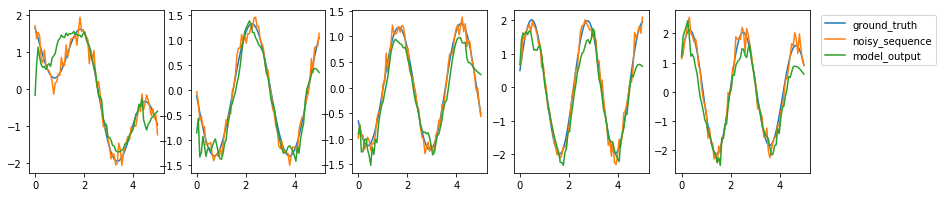

-112.6159% of noise removed.
epoch: 141, train loss:497.64886474609375
epoch: 141, validation loss:497.6488952636719
epoch: 142, train loss:496.53564453125
epoch: 142, validation loss:496.53564453125
epoch: 143, train loss:495.5346984863281
epoch: 143, validation loss:495.5346984863281
epoch: 144, train loss:494.6807861328125
epoch: 144, validation loss:494.6807861328125
epoch: 145, train loss:493.9918212890625
epoch: 145, validation loss:493.9918212890625
epoch: 146, train loss:493.4729309082031
epoch: 146, validation loss:493.4729309082031
epoch: 147, train loss:493.1170654296875
epoch: 147, validation loss:493.1170654296875
epoch: 148, train loss:492.9029235839844
epoch: 148, validation loss:492.9029541015625
epoch: 149, train loss:492.80194091796875
epoch: 149, validation loss:492.80194091796875


In [14]:
# epoch size increased
batch_size = 10
num_epochs = 150
learning_rate = 0.001
# noise removed: 112.6159%


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

epoch: 0, train loss:5382.2724609375
epoch: 0, validation loss:5382.2724609375


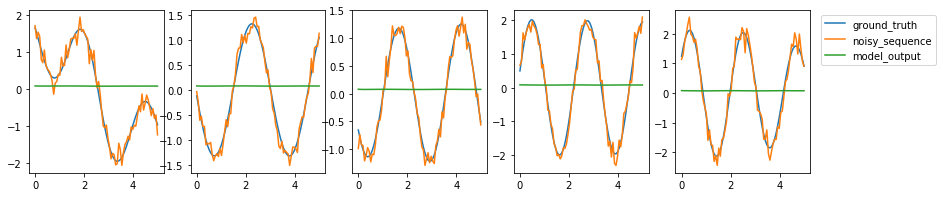

-637.7983% of noise removed.
epoch: 1, train loss:5335.68896484375
epoch: 1, validation loss:5335.68896484375
epoch: 2, train loss:5211.876953125
epoch: 2, validation loss:5211.876953125
epoch: 3, train loss:4797.73779296875
epoch: 3, validation loss:4797.73779296875
epoch: 4, train loss:3416.542236328125
epoch: 4, validation loss:3416.542236328125
epoch: 5, train loss:4224.81005859375
epoch: 5, validation loss:4224.81005859375
epoch: 6, train loss:3343.9541015625
epoch: 6, validation loss:3343.9541015625
epoch: 7, train loss:4358.1611328125
epoch: 7, validation loss:4358.16162109375
epoch: 8, train loss:4744.85400390625
epoch: 8, validation loss:4744.85400390625
epoch: 9, train loss:4916.20556640625
epoch: 9, validation loss:4916.20556640625
epoch: 10, train loss:5006.9990234375
epoch: 10, validation loss:5006.9990234375


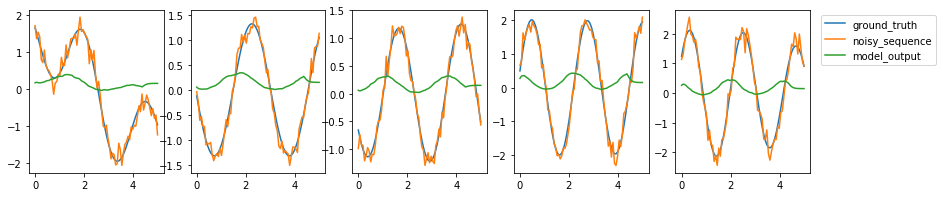

-613.4079% of noise removed.
epoch: 11, train loss:5060.9052734375
epoch: 11, validation loss:5060.9052734375
epoch: 12, train loss:5095.07470703125
epoch: 12, validation loss:5095.07470703125
epoch: 13, train loss:5119.37939453125
epoch: 13, validation loss:5119.37939453125
epoch: 14, train loss:5143.29541015625
epoch: 14, validation loss:5143.29541015625
epoch: 15, train loss:5179.92236328125
epoch: 15, validation loss:5179.92236328125
epoch: 16, train loss:5249.57421875
epoch: 16, validation loss:5249.57421875
epoch: 17, train loss:5376.66162109375
epoch: 17, validation loss:5376.662109375
epoch: 18, train loss:5561.39794921875
epoch: 18, validation loss:5561.39794921875
epoch: 19, train loss:5714.00048828125
epoch: 19, validation loss:5714.0009765625
epoch: 20, train loss:5664.8466796875
epoch: 20, validation loss:5664.8466796875


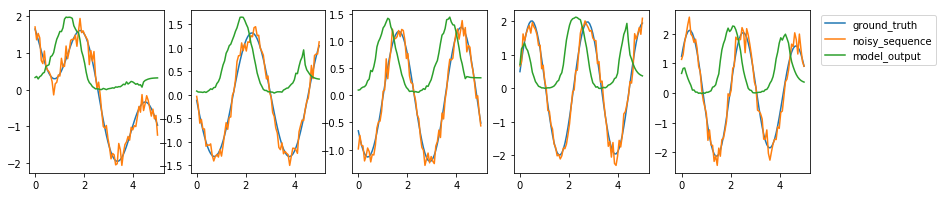

-651.4823% of noise removed.
epoch: 21, train loss:5376.42529296875
epoch: 21, validation loss:5376.42529296875
epoch: 22, train loss:5017.9921875
epoch: 22, validation loss:5017.99169921875
epoch: 23, train loss:4784.4853515625
epoch: 23, validation loss:4784.4853515625
epoch: 24, train loss:4728.10693359375
epoch: 24, validation loss:4728.10693359375
epoch: 25, train loss:4760.150390625
epoch: 25, validation loss:4760.150390625
epoch: 26, train loss:4727.21337890625
epoch: 26, validation loss:4727.21337890625
epoch: 27, train loss:4514.46435546875
epoch: 27, validation loss:4514.46435546875
epoch: 28, train loss:4183.2451171875
epoch: 28, validation loss:4183.2451171875
epoch: 29, train loss:3868.32861328125
epoch: 29, validation loss:3868.32861328125
epoch: 30, train loss:3718.849853515625
epoch: 30, validation loss:3718.849853515625


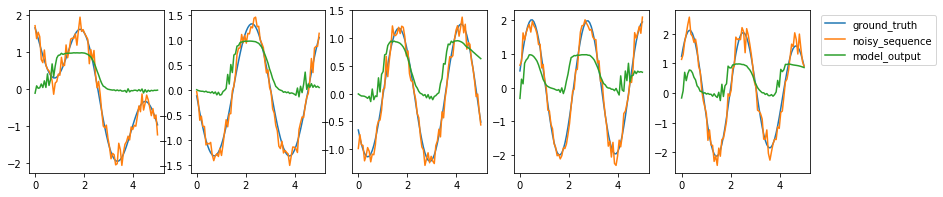

-475.2246% of noise removed.
epoch: 31, train loss:4012.257080078125
epoch: 31, validation loss:4012.257080078125
epoch: 32, train loss:4802.509765625
epoch: 32, validation loss:4802.509765625
epoch: 33, train loss:4965.9150390625
epoch: 33, validation loss:4965.9150390625
epoch: 34, train loss:3922.060546875
epoch: 34, validation loss:3922.060791015625
epoch: 35, train loss:3202.882080078125
epoch: 35, validation loss:3202.882080078125
epoch: 36, train loss:3616.319091796875
epoch: 36, validation loss:3616.319091796875
epoch: 37, train loss:4530.57470703125
epoch: 37, validation loss:4530.57470703125
epoch: 38, train loss:5085.5048828125
epoch: 38, validation loss:5085.5048828125
epoch: 39, train loss:5340.0322265625
epoch: 39, validation loss:5340.0322265625
epoch: 40, train loss:5524.5810546875
epoch: 40, validation loss:5524.5810546875


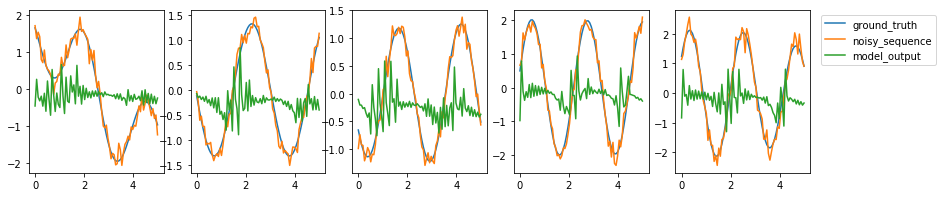

-656.3997% of noise removed.
epoch: 41, train loss:5387.22265625
epoch: 41, validation loss:5387.22265625
epoch: 42, train loss:5179.51708984375
epoch: 42, validation loss:5179.51708984375
epoch: 43, train loss:5035.18310546875
epoch: 43, validation loss:5035.1826171875
epoch: 44, train loss:4865.73046875
epoch: 44, validation loss:4865.73046875
epoch: 45, train loss:4708.8681640625
epoch: 45, validation loss:4708.8681640625
epoch: 46, train loss:4561.48828125
epoch: 46, validation loss:4561.48828125
epoch: 47, train loss:4391.8017578125
epoch: 47, validation loss:4391.8017578125
epoch: 48, train loss:4197.79150390625
epoch: 48, validation loss:4197.79150390625
epoch: 49, train loss:3996.739501953125
epoch: 49, validation loss:3996.739501953125
epoch: 50, train loss:3809.9326171875
epoch: 50, validation loss:3809.9326171875


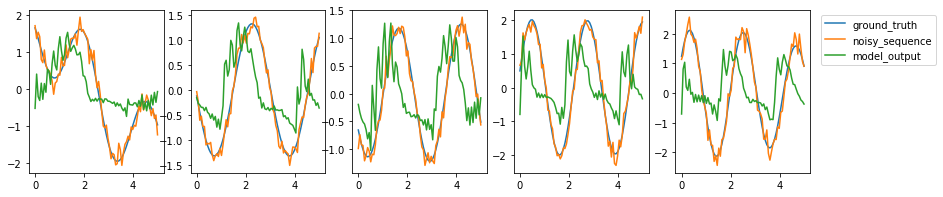

-508.8298% of noise removed.
epoch: 51, train loss:3627.103271484375
epoch: 51, validation loss:3627.103271484375
epoch: 52, train loss:3428.1298828125
epoch: 52, validation loss:3428.129638671875
epoch: 53, train loss:3205.123291015625
epoch: 53, validation loss:3205.123779296875
epoch: 54, train loss:2955.785888671875
epoch: 54, validation loss:2955.785888671875
epoch: 55, train loss:2688.238037109375
epoch: 55, validation loss:2688.238037109375
epoch: 56, train loss:2500.331298828125
epoch: 56, validation loss:2500.331298828125
epoch: 57, train loss:2563.794189453125
epoch: 57, validation loss:2563.794189453125
epoch: 58, train loss:2970.506103515625
epoch: 58, validation loss:2970.506103515625
epoch: 59, train loss:3484.6767578125
epoch: 59, validation loss:3484.67626953125
epoch: 60, train loss:3582.518310546875
epoch: 60, validation loss:3582.518310546875


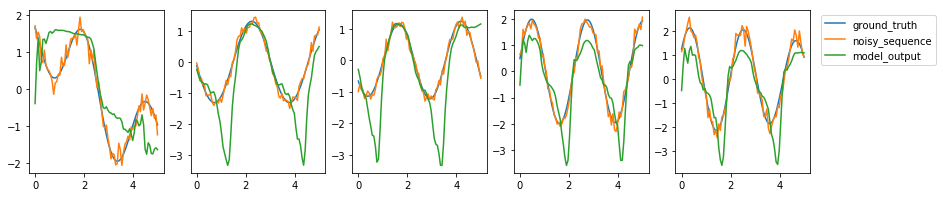

-491.1036% of noise removed.
epoch: 61, train loss:3198.855224609375
epoch: 61, validation loss:3198.855224609375
epoch: 62, train loss:2738.553466796875
epoch: 62, validation loss:2738.553466796875
epoch: 63, train loss:2412.51708984375
epoch: 63, validation loss:2412.517333984375
epoch: 64, train loss:2257.78369140625
epoch: 64, validation loss:2257.78369140625
epoch: 65, train loss:2209.73095703125
epoch: 65, validation loss:2209.73095703125
epoch: 66, train loss:2206.6875
epoch: 66, validation loss:2206.6875
epoch: 67, train loss:2234.450927734375
epoch: 67, validation loss:2234.450927734375
epoch: 68, train loss:2275.52001953125
epoch: 68, validation loss:2275.519775390625
epoch: 69, train loss:2314.356689453125
epoch: 69, validation loss:2314.356689453125
epoch: 70, train loss:2343.51220703125
epoch: 70, validation loss:2343.51220703125


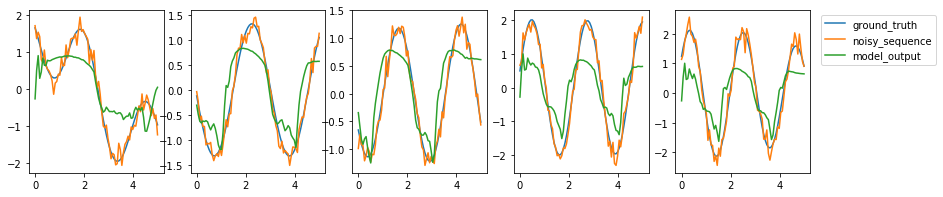

-376.1122% of noise removed.
epoch: 71, train loss:2360.630615234375
epoch: 71, validation loss:2360.630615234375
epoch: 72, train loss:2365.83935546875
epoch: 72, validation loss:2365.83935546875
epoch: 73, train loss:2360.31201171875
epoch: 73, validation loss:2360.31201171875
epoch: 74, train loss:2345.5439453125
epoch: 74, validation loss:2345.5439453125
epoch: 75, train loss:2323.0048828125
epoch: 75, validation loss:2323.005126953125
epoch: 76, train loss:2294.041015625
epoch: 76, validation loss:2294.040771484375
epoch: 77, train loss:2259.90673828125
epoch: 77, validation loss:2259.90673828125
epoch: 78, train loss:2221.843505859375
epoch: 78, validation loss:2221.843505859375
epoch: 79, train loss:2181.1455078125
epoch: 79, validation loss:2181.1455078125
epoch: 80, train loss:2139.175048828125
epoch: 80, validation loss:2139.175048828125


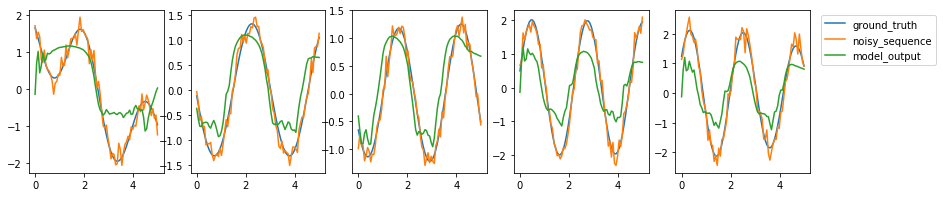

-363.9291% of noise removed.
epoch: 81, train loss:2097.32373046875
epoch: 81, validation loss:2097.32373046875
epoch: 82, train loss:2056.925537109375
epoch: 82, validation loss:2056.925537109375
epoch: 83, train loss:2019.1539306640625
epoch: 83, validation loss:2019.1539306640625
epoch: 84, train loss:1984.9168701171875
epoch: 84, validation loss:1984.9168701171875
epoch: 85, train loss:1954.79345703125
epoch: 85, validation loss:1954.79345703125
epoch: 86, train loss:1929.010498046875
epoch: 86, validation loss:1929.0107421875
epoch: 87, train loss:1907.4764404296875
epoch: 87, validation loss:1907.4765625
epoch: 88, train loss:1889.853759765625
epoch: 88, validation loss:1889.853759765625
epoch: 89, train loss:1875.654052734375
epoch: 89, validation loss:1875.65380859375
epoch: 90, train loss:1864.33203125
epoch: 90, validation loss:1864.33203125


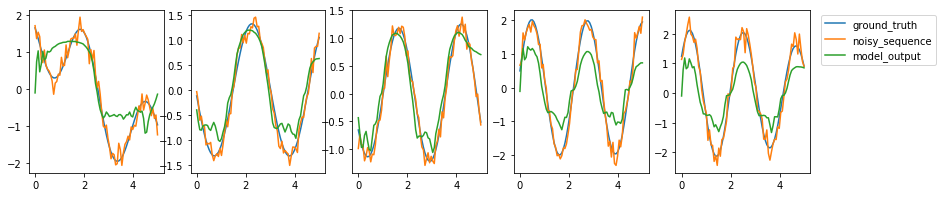

-323.2319% of noise removed.
epoch: 91, train loss:1855.3603515625
epoch: 91, validation loss:1855.3603515625
epoch: 92, train loss:1848.27587890625
epoch: 92, validation loss:1848.27587890625
epoch: 93, train loss:1842.7000732421875
epoch: 93, validation loss:1842.7003173828125
epoch: 94, train loss:1838.34326171875
epoch: 94, validation loss:1838.3433837890625
epoch: 95, train loss:1834.988525390625
epoch: 95, validation loss:1834.988525390625
epoch: 96, train loss:1832.474609375
epoch: 96, validation loss:1832.474365234375
epoch: 97, train loss:1830.67529296875
epoch: 97, validation loss:1830.6754150390625
epoch: 98, train loss:1829.4805908203125
epoch: 98, validation loss:1829.48046875
epoch: 99, train loss:1828.7799072265625
epoch: 99, validation loss:1828.7799072265625
epoch: 100, train loss:1828.4554443359375
epoch: 100, validation loss:1828.4554443359375


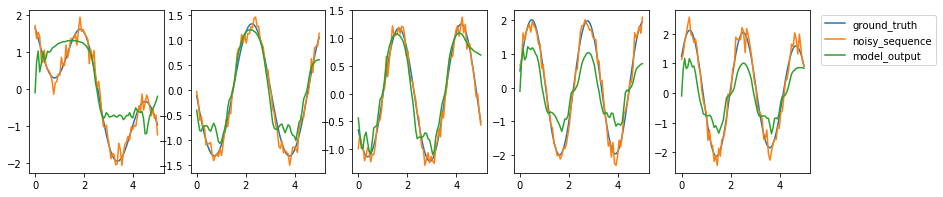

-316.4999% of noise removed.


In [15]:
# batch size increased
batch_size = 30
num_epochs = 101
learning_rate = 0.001
#noise removed: 316.4999%


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)


### Feedback

We invested about 4 hours. This task was interesting. But we don't know why we get these weird numbers as removed noise.